# Fashion MNIST

I mange år har MNIST-datasettet med håndskrevne tall blitt brukt både som benchmark og enkel illustrasjon av maskinlæring med bilder. Her bruker vi et veldig lignende datasett, med små svart-hvitt bilder av klesplagg. Vi skulle gjerne brukt et mer realistisk datasett, men grunnet begrensninger i prosessorkraft velger vi å holde oss til det enkle.

I dette enkle eksempelet begynner vi med to enkle modeller, som tar utgangspunkt i tabulære data. Hver piksel i bildet har en kolonne, nummerert pixel1-pixel784. Vi starter med en multiclass logistisk modell som predikerer type klesplagg, før vi går over til en neural-net modell som bruker det samme tabulære datasettet. Til slutt omformes dataene til bilder, og vi lager en neural-net modell for bildegjenkjenning.

In [1]:
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression

train = pd.read_csv('/data/kurs/python/fashionmnist/fashion-mnist_train.csv')
test = pd.read_csv('/data/kurs/python/fashionmnist/fashion-mnist_test.csv')

In [2]:
train.dtypes.head()

label     int64
pixel1    int64
pixel2    int64
pixel3    int64
pixel4    int64
dtype: object

In [3]:
train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
X_train, y_train = train.iloc[:,1:].values/255, train.iloc[:,0].values
X_test, y_test = test.iloc[:,1:].values/255, test.iloc[:,0].values

In [5]:
from sklearn.linear_model import LogisticRegression
fashion_logreg = LogisticRegression(multi_class='multinomial', solver='saga', penalty='none', max_iter=10)


In [6]:
fashion_logreg.fit(X_train, y_train)

/opt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10,
                   multi_class='multinomial', n_jobs=None, penalty='none',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [7]:
y_pred = fashion_logreg.predict(X_test)

sum(y_pred==y_test) / len(y_pred)

0.8585

## Keras
Her kjører vi en enkel tensorflow/Keras modell på de samme dataene. Fordi dette datasettet er så godt tilrettelagt, har vi ikke behov for preprosessering.

In [8]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation

In [9]:
y_train_onehot = pd.get_dummies(train.iloc[:,0].astype('str'))
y_test_onehot = pd.get_dummies(test.iloc[:,0].astype('str'))


y_train_onehot.shape

(60000, 10)

In [10]:
model = Sequential()
model.add(Dense(512, input_shape = (X_test.shape[1],)))
model.add(Activation('relu'))
model.add(Dense(256))
model.add(Dense(y_train_onehot.shape[1]))
model.add(Activation('softmax'))

In [11]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [12]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               401920    
_________________________________________________________________
activation (Activation)      (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                2570      
_________________________________________________________________
activation_1 (Activation)    (None, 10)                0         
Total params: 535,818
Trainable params: 535,818
Non-trainable params: 0
_________________________________________________________________


In [13]:
history = model.fit(X_train, y_train_onehot,
                    validation_data = (X_test, y_test_onehot),
                    batch_size=512,
                    epochs=3)

Train on 60000 samples, validate on 10000 samples
Epoch 1/3
60000/60000 [==============================] - 3s 57us/step - loss: 0.5660 - acc: 0.8028 - val_loss: 0.4272 - val_acc: 0.8521
Epoch 2/3
60000/60000 [==============================] - 3s 58us/step - loss: 0.3868 - acc: 0.8620 - val_loss: 0.3679 - val_acc: 0.8699
Epoch 3/3
60000/60000 [==============================] - 3s 44us/step - loss: 0.3387 - acc: 0.8782 - val_loss: 0.3369 - val_acc: 0.8791


## Bildegjenkjenning

For å behandle dataene som et bilde trenger vi å omforme de til faktiske bilder, eller rettere sagt numpy-representasjonen av bilder.

Under gjør vi egentlig to ting samtidig: Vi bruker reshape til å omforme dimensjonen på X_train, slik at dimensjon 0 er bilder, dimensjon 1 er høyde(?) og dimensjon 2 er bredde. Men vi legger også på en ekstra, tom dimensjon, slik at den endelige dimensjonen er `(60000, 28, 28, 1)` heller enn `(60000, 28, 28)`. Dette er egentlig en teknikalitet, som gir seg utslag ikke i hvordan vi ser bildet, men hvordan verdiene er nøstet i matrisen. Grunnen til at vi gjør det er at det er dette nettverket under forventer.

In [14]:
import matplotlib.pyplot as plt

import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.losses import categorical_crossentropy

In [15]:
X_train_3d = X_train.reshape((60000, 28, 28))[:,:,:,None]

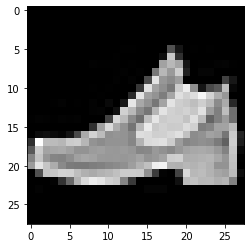

In [16]:
plt.imshow(X_train_3d[1,:,:,0], cmap='gray')

sklearn skjuler litt kompleksitet for oss når Y i et klassifikasjonsproblem kan være tall fra 0 til 9. Keras skjuler også veldig mye kompleksitet, men ikke akkurat dette. Nettverket vi lager må ta som input 28x28 bilder, output må være et en dummyenkodet utgave av Y, med andre ord et array av lengde 10.

In [17]:
y_train_onehot = pd.get_dummies(train.iloc[:,0].astype('str'))

y_train_onehot.shape

(60000, 10)

Nettverket er et enkelt sekvensielt nettverk, med to konvolusjonelle lag som flates og etterfølges av to Dense lag.

In [18]:
classifier = Sequential()

classifier.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape = (28, 28, 1) ))
classifier.add(Conv2D(64, (3, 3), activation='relu'))
classifier.add(MaxPooling2D(pool_size = (3, 3)))

classifier.add(Flatten())

classifier.add(Dense(64, activation='relu'))
classifier.add(Dense(32, activation='relu'))
classifier.add(Dense(y_train_onehot.shape[1]))
classifier.add(Activation('softmax'))

In [19]:
classifier.compile(optimizer = 'adam', loss = categorical_crossentropy, metrics = ['accuracy'])

In [20]:
classifier.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 8, 8, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                262208    
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 10)                330       
__________

In [21]:
yhot_test = pd.get_dummies(test.iloc[:,0].astype('str'))
yhot_test.shape

(10000, 10)

In [22]:
X_test = test.iloc[:,1:].to_numpy().reshape((10000, 28, 28))[:,:,:,None]
X_test.shape

(10000, 28, 28, 1)

In [23]:
classifier.fit( X_train_3d, y_train_onehot,
                        epochs=3,
                         validation_data=(X_test, yhot_test)
                        )

Train on 60000 samples, validate on 10000 samples
Epoch 1/3
60000/60000 [==============================] - 38s 629us/step - loss: 0.4653 - acc: 0.8329 - val_loss: 2.0038 - val_acc: 0.8718
Epoch 2/3
60000/60000 [==============================] - 37s 623us/step - loss: 0.2843 - acc: 0.8988 - val_loss: 2.0843 - val_acc: 0.8664
Epoch 3/3
60000/60000 [==============================] - 39s 646us/step - loss: 0.2388 - acc: 0.9119 - val_loss: 1.7298 - val_acc: 0.8899


En kjapp forklaring av tapsfunksjonen vår, categorical_crossentropy:

Output av funksjonen er en vektor med sannsynligheter for hver klasse, altså tall mellom 0 og 1. Y er en vektor med de sanne klassene, altså en vektor med 0 i alle elementer unntatt den sanne klassen, hvor vektoren er 1.

Enhver funksjon som blir lavere desto mindre foskjellen mellom disse to vektorene er, vil kunne fungere som tapsfunksjon. categorical_crossentropy (her illustrert med spesialtilfellet binary_crossentropy) er som følger:


$$-\frac{1}{N}\sum{y_{i}*log(p_{i}) + (1-y_{i})*log(1-p_{i})}$$

For å få en litt bedre forståelse er kanskje denne kalkulatoren grei:

In [24]:
import math
# i eksempelet er y=1, så tapet blir lavere jo nærmere p er 1
p=0.99

-(1*math.log(p) + 0*(1-math.log(1-p)))


0.01005033585350145

## Prøv selv

Et par forslag til ting å gjøre

- Bruk koden fra forrige notebook, og legg til støy på bildene før du trener. Hvordan påvirker dette resultatet?
- Etter å ha trent en modell på støyete data, kjør validering på både støyete og ustøyete data. Hvilken fungerer best?
- Mange modeller har problemer med overfitting, at modellen lærer seg egenskaper som er spesifikke for treningsdatasettet. Konsulter internettet, og undersøk hvordan `Dropout()`-lag og l2-regularisering kan hjelpe med dette.